In [2]:
import pandas as pd
import numpy as np

import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import pickle 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
import json

import sys; sys.path.append("..")
from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.mandate_wearing as mw

In [3]:
# prep data object
MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
MASKS = "wearing" #args.masks

path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
masks_object = Preprocess_masks(path=path)

masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, n_mandates = 2)
masks_object.make_preprocessed_object()
data = masks_object.data


# just mobility
path = "../data/modelling_set/master_data_mob_include_us_True_m_w.csv"
mobility_data = pd.read_csv(path)
mobility_data = mobility_data.set_index(["country", "date"])



['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [11]:
PNAS_WIDTH_INCHES = 3.4252

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 7}

plt.rc('font', **font)
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=7)


def country_double_y_plot(Rs, df, tsize=9):
    nCols = 7
    nRs = len(Rs)
    nRows = int(np.ceil(nRs/nCols))
    
    fig, axes = plt.subplots(nrows=nRows, ncols=nCols, sharex=True, sharey=True, figsize=(PNAS_WIDTH_INCHES *3, nRows*1.2), dpi=300)
    legax = axes[0][0]
    #axes = axes[:][1:]
    i = 0
    for row in axes:
        for ax in row:
            if ax == legax:
                continue
                
            if i == 0:
                ax.set_yticks([0, 50, 100])
                ax.set_yticklabels([0, 50, 100])
                ax.yaxis.set_tick_params(labelleft=True)
            
            if len(Rs) <= i :
                break
            
            c = Rs[i]
            
            cs = df[df.country == c]
            lns = ax.plot(cs.date, cs.percent_mc * 100, linewidth=0.7, label="   wearing")
            
            ax2 = ax.twinx()
            lns2 = ax2.plot(cs.date, cs.NewCases, label = '   cases', linewidth=0.5, color="green")
            
            if len(c) > 16:
                tsize = 7
            ax.set_title(c, fontsize=tsize)
            
            switch = mw.get_mandate_switches(cs)
            if len(switch):
                for d in switch.date:
                    man = plt.axvline(x=d, color="black", linestyle="--", label="   mandate",  linewidth=0.5)
            
            locator = mdates.MonthLocator()  # every month
            ax.xaxis.set_major_locator(locator)            
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
            ax.tick_params(axis='y', labelsize=6)
            #ax.tick_params(axis="x", labelsize=8)

            ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
            ax.set_ylim(0, 100)
            #ax2.set_ylim(0, cs.NewCases.max())
            ax2.set_yscale('log')

            ax2.yaxis.set_major_formatter(mtick.EngFormatter(sep=""))
            [i.set_linewidth(0.1) for i in ax.spines.values()]
            #xlabels = ['{:,.2f}'.format(x) + 'k' for x in ax.get_xticks()/1000]
            #ax2.set_xticklabels(xlabels)
            
            i += 1

    #fig.text(0.5, -0.02, '2020', ha='center', fontsize=16)
    fig.text(-0.02, 0.5, "% mask wearing", va='center', fontsize=16, rotation='vertical')
    fig.text(1.02, 0.5, "new daily cases", va='center', fontsize=16, rotation='vertical')
    
    lns = lns+lns2+[man]
    labs = [l.get_label() for l in lns] 
    legax.legend(lns, labs, frameon=False, fontsize=10)
    legax.axis('off')

    plt.tight_layout(pad=0.6)
    
    for i in range(1,6):
        axes[-1][-i].axis("off")
        
    axes[-2][-1].xaxis.set_tick_params(labelbottom=True)
    axes[-2][-2].xaxis.set_tick_params(labelbottom=True)
    axes[-2][-3].xaxis.set_tick_params(labelbottom=True)

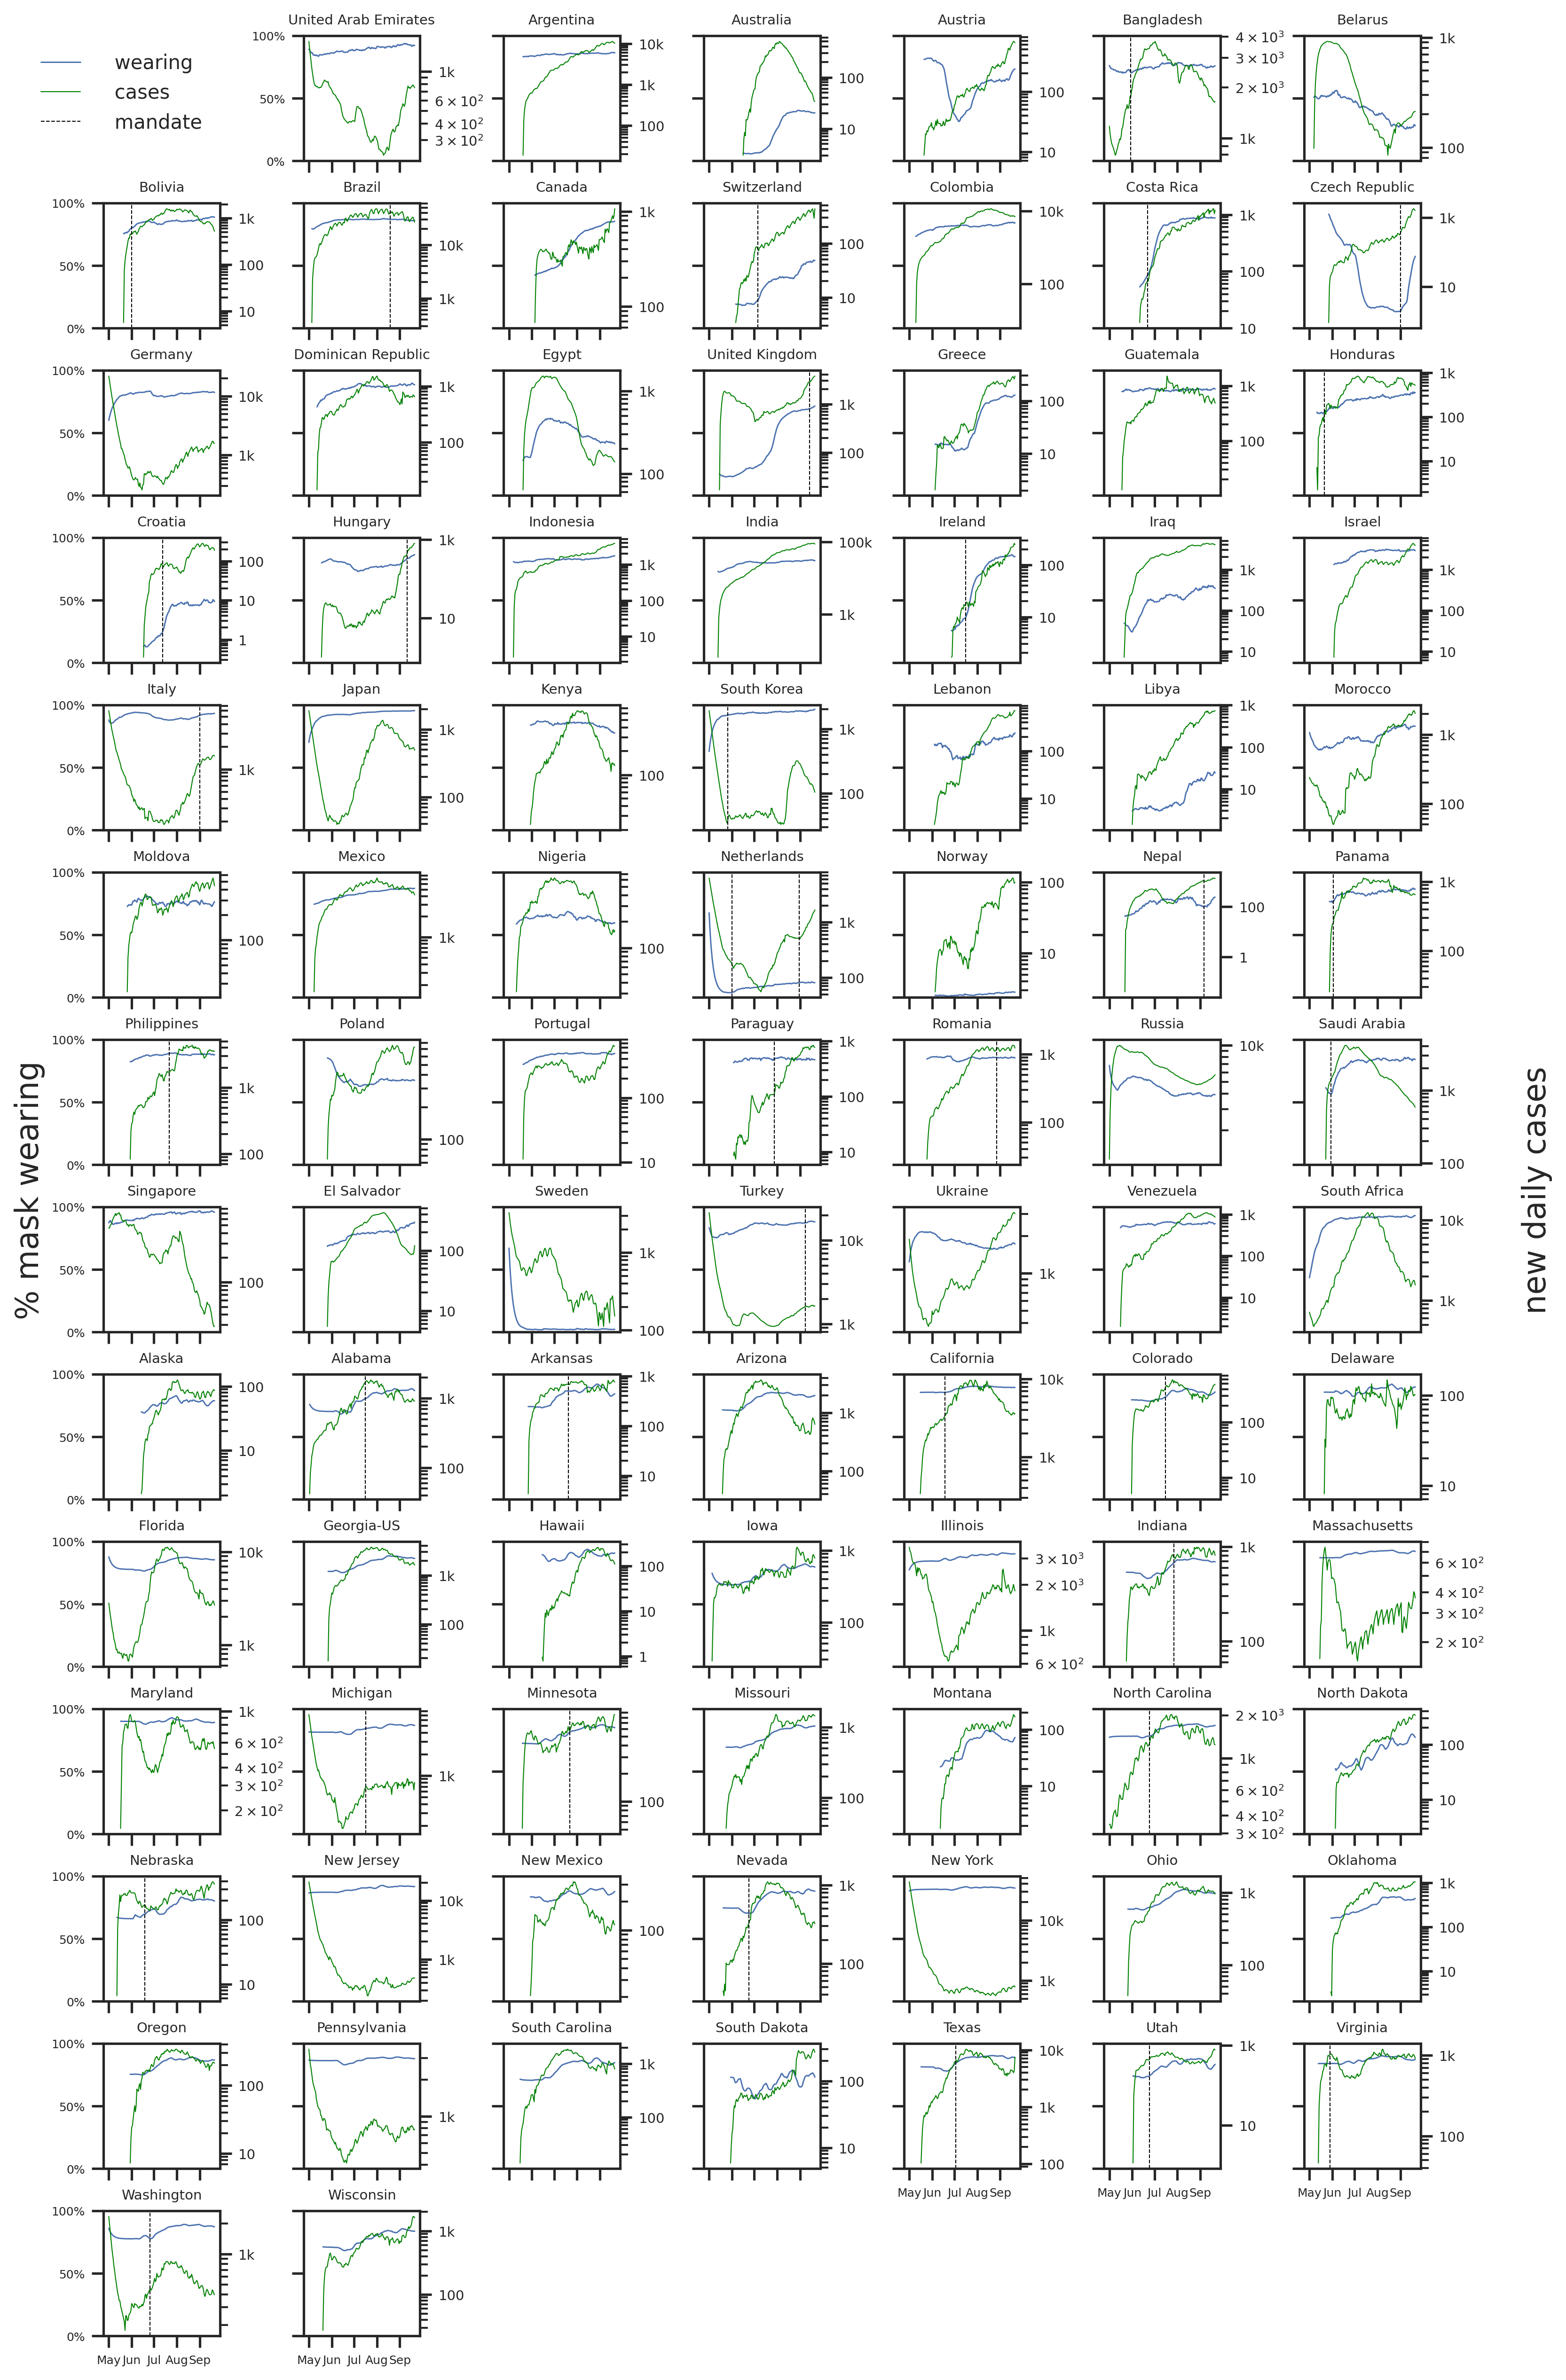

In [12]:
df = mobility_data.reset_index()
df["date"] = pd.to_datetime(df["date"])

df["NewCases"] = df.ConfirmedCases.diff()
df["percent_mc"] = df.ewm(span=10)["percent_mc"].mean()
df["NewCases"] = df.ewm(span=10)["NewCases"].mean()
df.loc[df["NewCases"] < 0] = 0
country_double_y_plot(data.Rs, df)


plt.savefig(f"../outputs/big_double_y_case_wearing.pdf", bbox_inches="tight")